<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [76]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

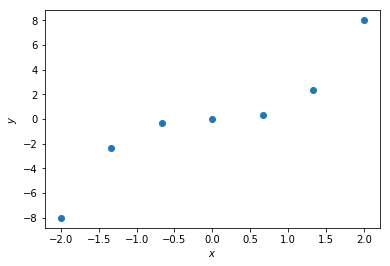

In [224]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

In [50]:
4.42**2


19.5364

In [194]:
np.mean(y)

0.4997

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [209]:
from sklearn.tree import DecisionTreeRegressor
     
reg_tree = DecisionTreeRegressor(max_depth=1, random_state=17)

reg_tree.fit(X, y)
#reg_tree_pred = reg_tree.predict(X_test)

ValueError: Expected 2D array, got 1D array instead:
array=[-2.         -1.33333337 -0.66666669  0.          0.66666669  1.33333337
  2.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

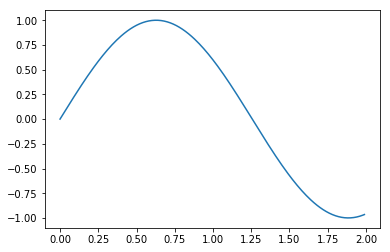

In [204]:
#plt.plot(X,np.mean(y))
t = np.arange(0.0, 2.0, 0.01)
s = np.sin(2.5*t)
plt.plot(t, s)

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [212]:
X

array([-2.        , -1.33333333, -0.66666667,  0.        ,  0.66666667,
        1.33333333,  2.        ])

In [211]:
y[:3]

array([-8.        , -2.37037037, -0.2962963 ])

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [48]:
def dispersion(a):
    av = sum(a)/len(a)
    s = 0
    for x in a:
        s += (x - av) * (x - av)
    return s/len(a)

def regression_var_criterion(X, t):
    
    np.var(y) - 3/7*np.var(y[:3]) - 4/7*np.var(y[3:])

19.916127767979617

In [215]:
dispersion(y) - 3/7* dispersion(y[:3]) - 4/7*dispersion(y[3:])

9.481481481481481

In [216]:
np.var(y) - 3/7*np.var(y[:3]) - 4/7*np.var(y[3:])

9.481481481481481

In [219]:
np.var(y) - 1/7*np.var(y[:1]) - 6/7*np.var(y[:1])

19.916127767979617

In [220]:
np.var(y) - 6/7*np.var(y[:6]) - 1/7*np.var(y[6:])

10.666666666666666

In [221]:
np.var(y) - 5/7*np.var(y[:5]) - 2/7*np.var(y[5:])

10.754458161865566

In [222]:
np.var(y) - 4/7*np.var(y[:4]) - 3/7*np.var(y[4:])

9.4814814814814774

In [223]:
np.var(y) - 2/7*np.var(y[:2]) - 5/7*np.var(y[2:])

10.754458161865568

In [231]:
np.mean(y[:1]), np.mean(y[1:3]), np.mean(y[3:6]), np.mean(y[6:])

(-8.0, -1.3333333333333337, 0.8888888888888884, 8.0)

In [230]:
y[3:6]

array([ 0.        ,  0.2962963 ,  2.37037037])

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [7]:
# Ваш код здесь

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [59]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [86]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,51,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,47,1,0,0,1,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [63]:
df['age_years'] = df['age_years'].astype('int64')

In [83]:
df = pd.get_dummies(data=df, columns=['cholesterol','gluc'])

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [84]:
y = df['cardio']
df.drop(['cardio'], axis=1, inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split (df.values, y, test_size=0.3,
                                                          random_state=17)

In [183]:
df_train = df[['ap_group_2', 'ap_group_1', 'ap_group_3', 'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
              'gender', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3', 'smoke']]
X_train, X_valid, y_train, y_valid = train_test_split (df_train.values, y, test_size=0.3,
                                                          random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [184]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

#%%time
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [185]:
export_graphviz(tree, 
                out_file='../../img/121.dot', filled=True)
!dot -Tpng ../../img/121.dot -o ../../img/121.png

In [97]:
X_train

array([[  1.82430000e+04,   2.00000000e+00,   1.69000000e+02, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.74450000e+04,   2.00000000e+00,   1.58000000e+02, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.26450000e+04,   1.00000000e+00,   1.65000000e+02, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.67400000e+04,   1.00000000e+00,   1.63000000e+02, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.65950000e+04,   2.00000000e+00,   1.60000000e+02, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.43730000e+04,   1.00000000e+00,   1.73000000e+02, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [114]:
tree_pred = tree.predict(X_valid)
acc1 = accuracy_score(y_valid, tree_pred)

In [100]:
X_valid

array([[  2.10890000e+04,   2.00000000e+00,   1.65000000e+02, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.19450000e+04,   2.00000000e+00,   1.75000000e+02, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.25090000e+04,   2.00000000e+00,   1.66000000e+02, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  2.31530000e+04,   1.00000000e+00,   1.60000000e+02, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.43920000e+04,   1.00000000e+00,   1.57000000e+02, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.66940000e+04,   1.00000000e+00,   1.70000000e+02, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [101]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True) # Ваш код здесь

In [102]:
tree_grid.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [103]:
tree_grid.best_params_

{'max_depth': 6}

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [187]:
tree_grid.grid_scores_

/Users/maxsagitov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.71551, std: 0.00363, params: {'max_depth': 2},
 mean: 0.72771, std: 0.00485, params: {'max_depth': 3},
 mean: 0.73049, std: 0.00453, params: {'max_depth': 4},
 mean: 0.73096, std: 0.00523, params: {'max_depth': 5},
 mean: 0.73196, std: 0.00503, params: {'max_depth': 6},
 mean: 0.73043, std: 0.00355, params: {'max_depth': 7},
 mean: 0.72959, std: 0.00406, params: {'max_depth': 8},
 mean: 0.72778, std: 0.00483, params: {'max_depth': 9},
 mean: 0.72614, std: 0.00523, params: {'max_depth': 10}]

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [115]:
acc2 = accuracy_score(y_valid, tree_grid.predict(X_valid))
#tree_pred = tree.predict(X_valid)
#accuracy_score(y_valid, tree_pred)

In [117]:
(acc2 - acc1) / acc1 * 100

0.62718690169670022

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [164]:
df['age_group'] = pd.cut(df['age_years'], [44,49,54,59,64], labels = [1,2,3,4])

In [173]:
df['ap_group'] = pd.cut(df['ap_hi'], [119,139,159,179], labels = [1,2,3])
df = pd.get_dummies(data=df, columns=['ap_group'])
df

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,...,gluc_1,gluc_2,gluc_3,age_group_1,age_group_2,age_group_3,age_group_4,ap_group_1,ap_group_2,ap_group_3
id,,,,,,,,,,,,,,,,,,,,,
0,18393,1,168,62.0,110,80,0,0,1,50,...,1,0,0,0,1,0,0,0,0,0
1,20228,0,156,85.0,140,90,0,0,1,55,...,1,0,0,0,0,1,0,0,1,0
2,18857,0,165,64.0,130,70,0,0,0,51,...,1,0,0,0,1,0,0,1,0,0
3,17623,1,169,82.0,150,100,0,0,1,48,...,1,0,0,1,0,0,0,0,1,0
4,17474,0,156,56.0,100,60,0,0,0,47,...,1,0,0,1,0,0,0,0,0,0
8,21914,0,151,67.0,120,80,0,0,0,60,...,0,1,0,0,0,0,1,1,0,0
9,22113,0,157,93.0,130,80,0,0,1,60,...,1,0,0,0,0,0,1,1,0,0
12,22584,1,178,95.0,130,90,0,0,1,61,...,0,0,1,0,0,0,1,1,0,0
13,17668,0,158,71.0,110,70,0,0,1,48,...,1,0,0,1,0,0,0,0,0,0


In [156]:
my_map = {1:0, 2:1}
df['gender'] = df.gender.map(my_map)
    

In [166]:
df = pd.get_dummies(data=df, columns=['age_group'])


In [180]:
X_train, X_valid, y_train, y_valid = train_test_split (df_train.values, y, test_size=0.3,
                                                          random_state=17)